# Evaluating Meta's Llama 3.1 8B Instruct on MMLU

## Preface

I recently participated in the original cohort of Dan Becker and Hamel Husain's Mastering LLMs: A Conference For Developers & Data Scientists. I eagerly sopped up every video, hungry for lessons from the experts at the cutting edge of the field.

After the course I felt I had gained a huge amount of knowledge, but I hadn't gotten my hands dirty, yet. This blog is to change that.

Evaluations, which almost every speaker emphasized as being one of, if not the most, important piece of the LLM pipeline puzzle, seemed like a good place to start.

So, project number one: Create an evaluation framework to run models on benchmarks. To simplify things further I decided to focus on Meta's Llama 3.1 8B Instruct model and the MMLU benchmark.

And, to spice things up a bit, I decided to attempt to reproduce Meta's [stated score](https://ai.meta.com/blog/meta-llama-3-1/#:~:text=of%20partner%20platforms.-,Model,-evaluations) of 73.0 for Llama 3.1 8B.

## Gear

I use an Intel based Macbook Pro running VSCode, Google Colab, terminal, and the occasional use of basic Jupyter Notebooks. I also used a Claude 3.5 Sonnet Project in its web interface to assist my thoughts and code.

## Setup

To download our model we will use the Hugging Face Hub. This means that we will need to get and set a Hugging Face token to use in this project. Instructions for how to go about it can be found [here](https://https://huggingface.co/docs/huggingface_hub/v0.23.3/en/quick-start).

Once we have our HF_TOKEN saved to our Google Colab secrets we can install and setup the Hugging Face Hub.

In [ ]:
!pip install huggingface_hub

In [2]:
import os

# Import Colab Secrets userdata module
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

## The evaluation framework

[https://github.com/chuckfinca/evaluate](https://github.com/chuckfinca/evaluate)

The goal here was to create a framework that would take a model and a benchmark as input and return the model's score on that benchmark as output.

My thinking was that if I could make it easy to run any model on any benchmark then I could use that framework in a pipeline that ran models through sets of existing and custom benchmarks alike.

The framework uses an orchestrator pattern in which a benchmark specific orchestrator class (e.g. MMLUBenchmarkOrchestrator) facilitates the evaluation of a model on a benchmark. 

The heart of the MMLUBenchmarkOrchestrator is its subject evaluation function:

In [ ]:
import torch
import numpy as np

def _eval_subject(self, subject, dev_df, test_df):
    cors = []
    preds = []
    probs = []

    for i in range(len(test_df)):
        prompt = self._format_prompt(dev_df, test_df, i)
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        logits = outputs.logits[0, -1]
        probs_i = torch.nn.functional.softmax(logits, dim=-1)
        
        choice_probs = [probs_i[self.tokenizer.encode(choice, add_special_tokens=False)[0]].item() for choice in self.choices]
        pred = {0: "A", 1: "B", 2: "C", 3: "D"}[np.argmax(choice_probs)]
        
        probs.append(choice_probs)
        preds.append(pred)
        cors.append(pred == test_df.iloc[i, 5])

    acc = np.mean(cors)
    print(f"{subject} Accuracy: {acc:.3f}")

    return cors, acc, probs

The function takes dev and test data for a given MMLU subject and evaluates the model using the following steps:

1. Creates model prompts from evaluation questions and few-shot examples
2. Tokenizes prompts and moves them to model's device
3. Runs inference using the prompts (aka. asks the model the questions)
4. Extracts probabilities from model outputs
5. Predicts answers based on highest probability
6. Calculates accuracy for the subject

To see all this in action let's import the project now:

In [5]:
!git clone https://github.com/chuckfinca/evaluate

Cloning into 'evaluate'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 261 (delta 150), reused 205 (delta 94), pack-reused 0 (from 0)
Receiving objects: 100% (261/261), 36.00 KiB | 18.00 MiB/s, done.
Resolving deltas: 100% (150/150), done.


The project has one dependency, so let's import that:

In [6]:
!pip install python-dotenv

Note: At some point I intend to make my evaluation framework into a python package in order to simplify some of this, but we'll save that work for a later date.

## Putting it all together

Now that we've got our evaluation framework ready to go let's see if we can reproduce [Meta's stated score](https://ai.meta.com/blog/meta-llama-3-1/#:~:text=of%20partner%20platforms.-,Model,-evaluations) of 73.0 for Llama 3.1 8B!

I haven't yet been able to find a source in Meta's documentation that states that they used the Instruct version of their models for benchmarking, but I believe this is common practice and so I chose to use the `Meta-Llama-3.1-8B-Instruct` model in my experiment.

To run our script we just need to supply a few things. Our benchmark and model name, and the type of few-shot learning we want to use.

In their blog post, Meta states that they used 0-shot (COT) to generate their 73.0 score on MMLU. To keep things uniform we will use 0 shot learning. COT (aka. chain-of-thought) is beyond the scope of this post, so we'll leave that be for now.

> **_A note about hardware:_**  
>  
> I learned in the Mastering LLMs that a model generally requires 2 to 3x more RAM than it has billions of parameters. Our model has 8 billion parameters and so I expected to need between 16 and 24GB of GPU RAM to run the evaluation.  
>  
> In practice I used about 18GB. This meant that I was able to run the evaluation using both the Google Colab A100 and L4 GPU runtimes which both have 20+ GB of GPU RAM.  
>  
> The framework is also setup to use the CPU if cuda is not available. This worked on my local machine, but was too slow to be of any practical use.

Enough of that, let's see the results!

In [8]:
!python evaluate/evaluate/main.py --benchmark mmlu --model meta-llama/Meta-Llama-3.1-8B-Instruct --nshot 0

Benchmark 'mmlu' has been set up successfully.
Running evaluation 'mmlu' with:
Model: meta-llama/Meta-Llama-3.1-8B-Instruct
Number of training examples: 0
Device: cuda
Using dtype: torch.float16
Loading model from /content/evaluate/evaluate/models/saved/meta-llama/Meta-Llama-3.1-8B-Instruct
Loading checkpoint shards: 100% 4/4 [00:00<00:00, 12.08it/s]
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
abstract_algebra Accuracy: 0.340
anatomy Accuracy: 0.607
astronomy Accuracy: 0.757
business_ethics Accuracy: 0.640
clinical_knowledge Accuracy: 0.792
college_biology Accuracy: 0.812
college_chemistry Accuracy: 0.500
college_computer_science Accuracy: 0.480
college_mathematics Accuracy: 0.410
college_medicine Accuracy: 0.699
college_physics Accuracy: 0.412
computer_security Accuracy: 0.740
c

**Et voila!** We have our score.

Not what Meta reported, but not that far off either. I'll leave the discrepancy for future posts :)

To wrap up, let's create a way to visualize our findings:

In [ ]:
import os
model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct" #"google/gemma-2b-it" #
score_file = os.path.join(os.getcwd(),'evaluate', 'evaluate', 'benchmarks', 'benchmarks', 'mmlu', 'results', model_name, "mmlu_score.txt")
with open(score_file, 'r') as file:
    score = file.read()
print(score)

66.600


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def create_mmlu_comparison_chart(realized_score, reported_score, model_name):
    """
    Create a bar chart comparing current and previous MMLU scores.

    :param realized_score: float, the current evaluation score
    :param reported_score: float, the previous evaluation score
    :param model_name: str, the name of the model being evaluated
    :return: Matplotlib figure object
    """

    # Data
    evaluation = ['Reported', 'Realized']
    scores = [float(reported_score), float(realized_score)]

    # Create bar chart
    fig, ax = plt.subplots(figsize=(12, 7))
    x_pos = np.arange(len(evaluation))
    bars = ax.bar(x_pos, scores, color=['#D3D3D3', '#4285F4'])

    # Customize the chart
    ax.set_ylabel('MMLU Score', fontsize=18)
    ax.set_title(f'MMLU Test Results: {model_name}', fontsize=18, fontweight='bold')
    ax.set_ylim(0, 100)  # Set y-axis from 0 to 100 for percentage scale

    # Set x-axis ticks and labels
    ax.set_xticks(x_pos)
    ax.set_xticklabels(evaluation, fontsize=18)

    # y-axis label
    ax.tick_params(axis='y', labelsize=18)

    # Add value labels on the bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=18)

    # Add a light grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Improve overall layout
    plt.tight_layout()

    return fig

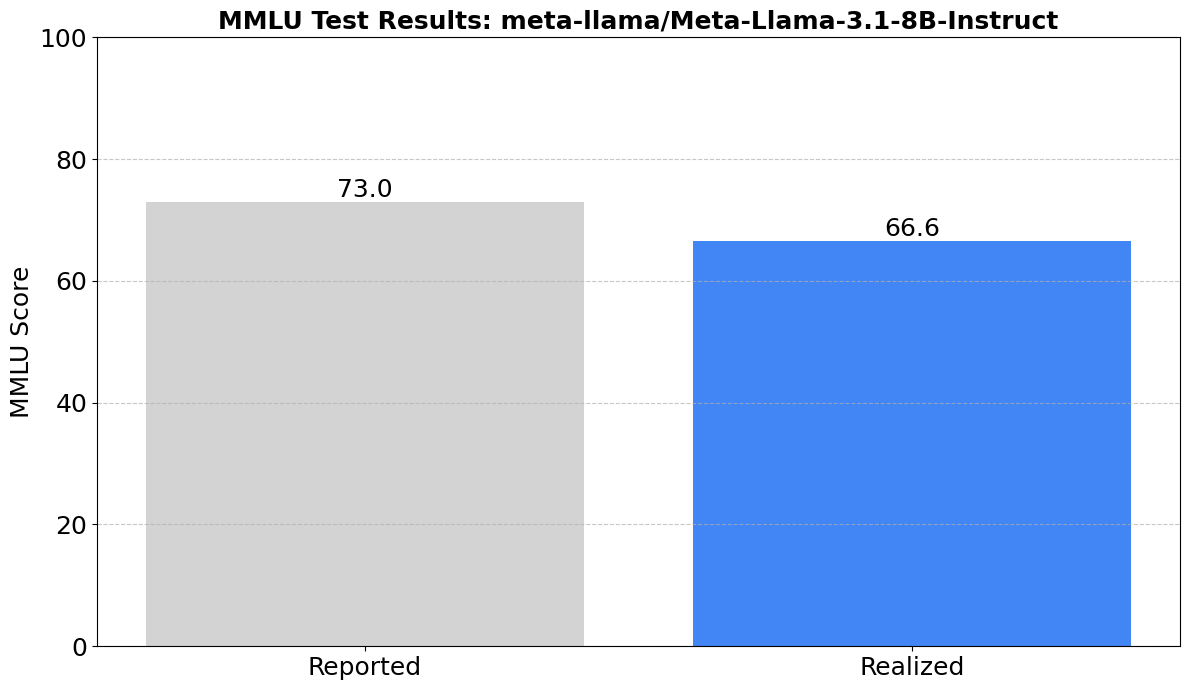

In [10]:
fig = create_mmlu_comparison_chart(realized_score=score, reported_score=73.0, model_name=model_name)
fig.show()

Thanks for following along! If you've got a questions or comment please feel free to email me at chuckfinca at google dot com.